## Librerías

In [1]:
# Libraries which will help us to manipulate a lil bit more our data
import numpy as np
import pandas as pd

# pandas: display all columns
pd.set_option('display.max_columns', None)

# Sklearn: Library for Train/Test Split // confusion matrix
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score

# TensorFlow: Library for model training
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

# Matplotlib: Library for plotting
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

# Functions: Library which contains all the functions that we'll use
import functions as fn

# Functions: Library which contains all the visualizations that we'll plot
import visualizations as vz

# Display plotly graphs in HTML
import plotly.io as pio
pio.renderers.default='notebook'

from collections import Counter

from CDIN import CDIN as eda

## Cargar datos

In [2]:
data= pd.read_parquet('Data_new_outliers.parquet')
data.drop(columns=["", "fraccion4", "Precio_raro", "articulo", "pais_origen_destino", "descripcion limpia", "descripcion", 
                   "TIGIE_D", "unidad_medida", "descripcion_unidad_medida", "codigo_pais", "continente"], inplace = True)

# Guardar en una variable el nombre de nuestra variable objetivo
target_variable ='outlier'

In [3]:
# Aplicar label encoder para castear texto a numérico
data = fn.label_encoder(data)

In [4]:
Counter(data["outlier"])

Counter({0: 887167, 1: 39122})

In [5]:
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc')
]

def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        keras.layers.Dense(
            16, activation='relu',
            input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)

    return model

# Weights

In [6]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(data, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

In [7]:
# Form np arrays of labels and features.
train_labels = np.array(train_df.pop(target_variable))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop(target_variable))
test_labels = np.array(test_df.pop(target_variable))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [8]:
scaler = StandardScaler()

train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

$$w_j = \frac{n}{kn_j}$$

$\text{Where}$ \
$w_j: \ \text{is the weight to class j}$ \
$n: \ \text{is the number of observations}$ \
$n_j: \ \text{is the number of observations in class j, and}$ \
$k: \ \text{is the total number of classes.}$


In [9]:
unique_classes = [0, 1]

In [10]:
class_weight  = {}
for classes in unique_classes:
    class_weight[classes] = data.shape[0]/((data.loc[data[target_variable] == classes].shape[0])*len(unique_classes))

In [11]:
class_weight

{0: 0.5220488363521186, 1: 11.838466847298195}

In [12]:
EPOCHS = 10
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [13]:
weighted_model = make_model()

In [14]:
weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight)

Epoch 1/10
290/290 [==============================] - 2s 4ms/step - loss: 0.6453 - accuracy: 0.7795 - precision: 0.0917 - recall: 0.4730 - auc: 0.6755 - val_loss: 0.5185 - val_accuracy: 0.8370 - val_precision: 0.1501 - val_recall: 0.6212 - val_auc: 0.8210
Epoch 2/10
290/290 [==============================] - 1s 3ms/step - loss: 0.5429 - accuracy: 0.8190 - precision: 0.1355 - recall: 0.6093 - auc: 0.7987 - val_loss: 0.4689 - val_accuracy: 0.8660 - val_precision: 0.1913 - val_recall: 0.6823 - val_auc: 0.8715
Epoch 3/10
290/290 [==============================] - 1s 3ms/step - loss: 0.4923 - accuracy: 0.8519 - precision: 0.1750 - recall: 0.6728 - auc: 0.8531 - val_loss: 0.4386 - val_accuracy: 0.8821 - val_precision: 0.2221 - val_recall: 0.7266 - val_auc: 0.9010
Epoch 4/10
290/290 [==============================] - 1s 3ms/step - loss: 0.4602 - accuracy: 0.8657 - precision: 0.1985 - recall: 0.7158 - auc: 0.8807 - val_loss: 0.4175 - val_accuracy: 0.8891 - val_precision: 0.2391 - val_recall: 0

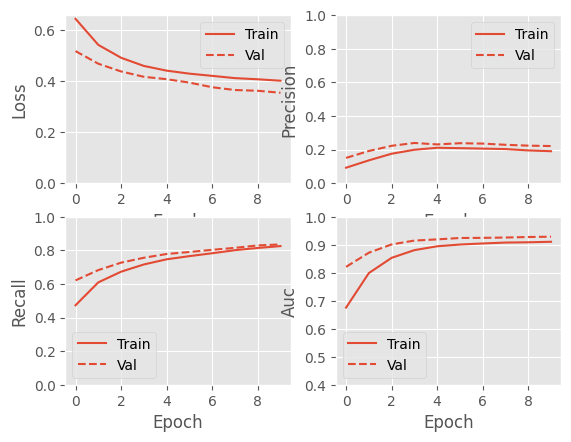

In [15]:
vz.plot_wmetrics(weighted_history)

In [16]:
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

91/91 [==============================] - 0s 981us/step


In [17]:
def plot_cm(labels, predictions, p=0.5):
    
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(9, 7))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate No-Outliers Detected (True Negatives): ', cm[0][0])
    print('Legitimate No-Outliers Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Outliers Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Outliers Detected (True Positives): ', cm[1][1])
    print('Total Outliers: ', np.sum(cm[1]))
    print('Total No-Outliers: ', np.sum(cm[0]))

Legitimate No-Outliers Detected (True Negatives):  154370
Legitimate No-Outliers Incorrectly Detected (False Positives):  23057
Fraudulent Outliers Missed (False Negatives):  1270
Fraudulent Outliers Detected (True Positives):  6561
Total Outliers:  7831
Total No-Outliers:  177427


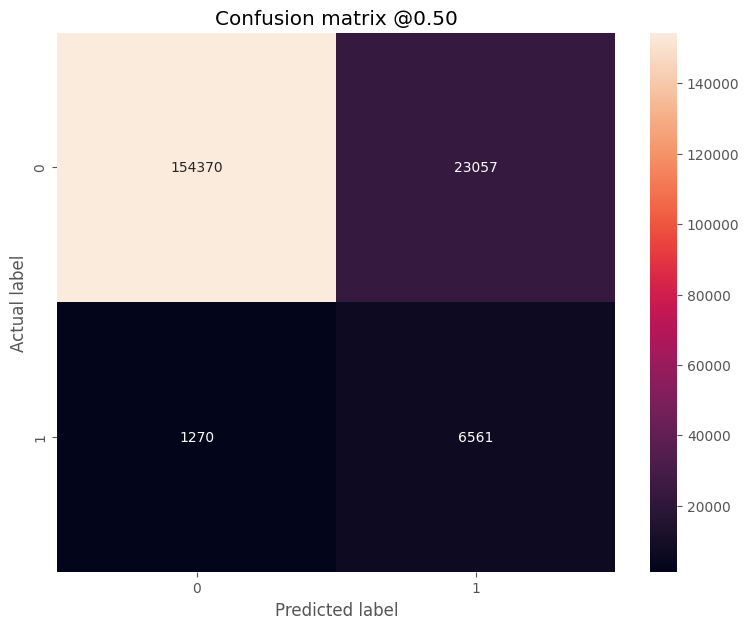

In [18]:
plot_cm(test_labels, test_predictions_weighted)

In [19]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', np.round(value, 2))

f1 = (2*weighted_results[2]*weighted_results[3])/(weighted_results[2]+weighted_results[3])
print("f1 : ", np.round(f1, 2))

loss :  0.35
accuracy :  0.87
precision :  0.22
recall :  0.84
auc :  0.93
f1 :  0.35


# Decile Analysis

In [20]:
decile_analysis = fn.decile_analysis(test_predictions_weighted, test_labels)
decile_analysis

,Batch,Cumulative Batch,Cumulative % Batch,True label,True label %,Cumulative label %,Probability Range
Decile,,,,,,,
1,18526,18526,0.1,5689,0.7265,0.7265,1.0 - 0.6265
2,18526,37052,0.2,1237,0.1580,0.8844,0.6265 - 0.426
3,18526,55578,0.3,491,0.0627,0.9471,0.426 - 0.2941
4,18526,74104,0.4,189,0.0241,0.9713,0.2941 - 0.2115
5,18526,92630,0.5,94,0.0120,0.9833,0.2115 - 0.1555
6,18526,111156,0.6,54,0.0069,0.9902,0.1555 - 0.1164
7,18526,129682,0.7,38,0.0049,0.9950,0.1164 - 0.0875
8,18526,148208,0.8,6,0.0008,0.9958,0.0875 - 0.068
9,18525,166733,0.9,9,0.0011,0.9969,0.068 - 0.0467


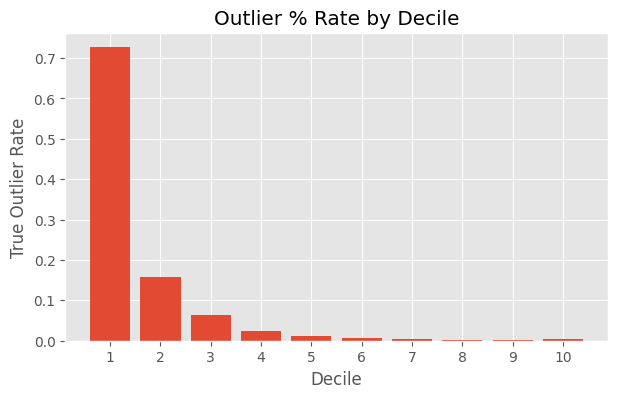

In [21]:
vz.decile_analysis_plot(decile_analysis["True label %"])

In [22]:
test_predictions_weighted = test_predictions_weighted.ravel()
test_predictions_weighted

array([0.1150553 , 0.02569348, 0.3382126 , ..., 0.24229908, 0.48085573,
       0.57810295], dtype=float32)

In [23]:
x = pd.qcut(test_predictions_weighted, 10)
x

[(0.0875, 0.116], (-0.001, 0.0467], (0.294, 0.426], (0.0467, 0.068], (0.294, 0.426], ..., (0.116, 0.156], (0.294, 0.426], (0.212, 0.294], (0.426, 0.627], (0.426, 0.627]]
Length: 185258
Categories (10, interval[float64, right]): [(-0.001, 0.0467] < (0.0467, 0.068] < (0.068, 0.0875] < (0.0875, 0.116] ... (0.212, 0.294] < (0.294, 0.426] < (0.426, 0.627] < (0.627, 1.0]]

In [24]:
z = pd.DataFrame(
    data = {
        "interval": x,
        "prob": test_predictions_weighted
    }
).sort_values(by = "prob")[::-1]
z

,interval,prob
23398,"(0.627, 1.0]",1.0
16859,"(0.627, 1.0]",1.0
90508,"(0.627, 1.0]",1.0
147506,"(0.627, 1.0]",1.0
127092,"(0.627, 1.0]",1.0
...,...,...
26441,"(-0.001, 0.0467]",0.0
177621,"(-0.001, 0.0467]",0.0
155313,"(-0.001, 0.0467]",0.0
88582,"(-0.001, 0.0467]",0.0


In [25]:
z.reset_index(inplace=True)
z.drop(columns=["index"], inplace=True)

In [26]:
z["interval"] = z["interval"].astype(str)

In [27]:
# test_df
# test_df.reset_index(inplace=True)
# test_df.drop(columns=["index"], inplace=True)

In [28]:
z = z.join(pd.DataFrame(test_features))

In [38]:
zdict = set(z["interval"])
zdict

{'(-0.001, 0.0467]',
 '(0.0467, 0.068]',
 '(0.068, 0.0875]',
 '(0.0875, 0.116]',
 '(0.116, 0.156]',
 '(0.156, 0.212]',
 '(0.212, 0.294]',
 '(0.294, 0.426]',
 '(0.426, 0.627]',
 '(0.627, 1.0]'}

In [41]:
xaa = {
    '(-0.001, 0.0467]':10,
 '(0.0467, 0.068]':9,
 '(0.068, 0.0875]':8,
 '(0.0875, 0.116]':7,
 '(0.116, 0.156]':6,
 '(0.156, 0.212]':5,
 '(0.212, 0.294]':4,
 '(0.294, 0.426]':3,
 '(0.426, 0.627]':2,
 '(0.627, 1.0]': 1
}

In [42]:
dict = {value:key for key, value in xaa.items()}

In [43]:
z["decile"] = z["interval"].map(xaa)

In [56]:
zgby = z.groupby(by=["decile"]).mean()

In [57]:
np.round(zgby,2).iloc[:,:17]

,prob,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
decile,,,,,,,,,,,,,,,,,
1,0.79,0.00,-0.01,0.01,-0.00,-0.01,0.01,0.00,-0.00,-0.00,0.00,0.02,0.00,-0.01,0.01,-0.0,-0.01
2,0.52,0.01,0.01,-0.00,-0.01,-0.01,-0.00,0.01,-0.00,0.00,0.01,-0.00,0.00,0.01,0.00,-0.0,0.01
3,0.36,-0.00,0.01,0.01,-0.01,0.01,-0.01,-0.00,-0.00,-0.01,-0.00,-0.00,0.00,-0.00,0.01,-0.0,0.01
4,0.25,0.00,-0.00,0.01,-0.00,-0.01,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.01,-0.0,-0.01
5,0.18,-0.00,0.00,0.00,-0.00,-0.00,0.00,0.01,0.04,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.0,0.00
6,0.13,0.01,-0.00,0.01,0.00,-0.00,0.01,-0.00,-0.00,-0.01,0.01,0.00,-0.01,0.01,0.01,-0.0,-0.00
7,0.10,0.00,0.01,-0.00,-0.00,0.00,0.01,-0.00,-0.00,0.00,0.00,0.00,0.01,0.00,-0.00,0.0,-0.02
8,0.08,-0.01,-0.00,0.01,-0.00,0.01,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.01,0.0,0.00
9,0.06,-0.01,0.00,0.00,0.00,-0.01,0.00,-0.00,-0.00,-0.00,-0.01,0.01,-0.00,-0.00,-0.00,0.0,0.00


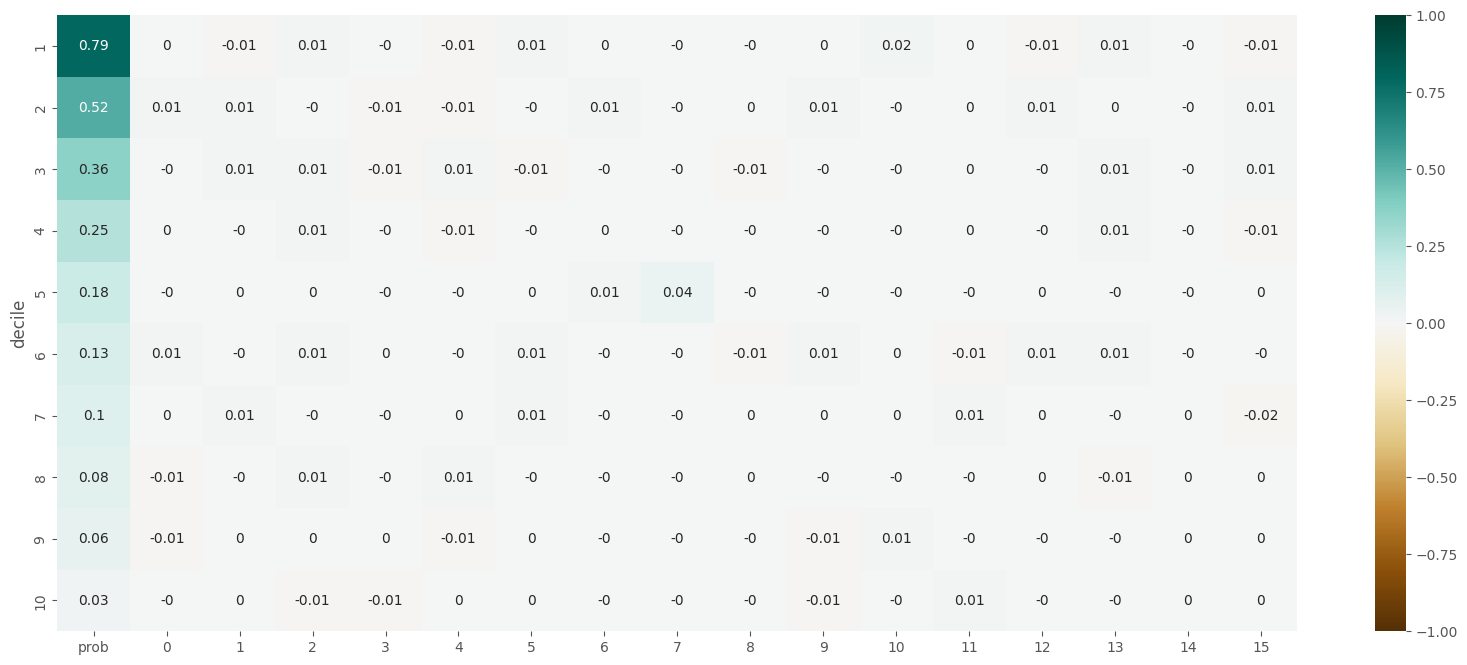

In [58]:
plt.figure(figsize=(20, 8))
sns.heatmap(np.round(np.round(zgby,2).iloc[:,:17],2), vmin=-1, vmax=1,annot=True, cmap='BrBG');